# Probabilistic Principal Component Analysis (PPCA)

~~~
Extracción de Características en Imágenes.
Master en Ciencia de Datos y Arquitectura de los Computadores.
Universidad de Granada.


Fernando Pérez Bueno - fpb@ugr.es
Rafael Molina Soriano - rms@decsai.ugr.es
~~~

En este guión, vamos a estudiar la versión probabilistica del análisis de componentes principales. Esto nos va a permitir, por un lado, mirar al modelo PCA que hemos estudiado desde otro punto de vista (modelo generativo) y, por otro,  introducir un modelo  que nos va a permitir avanzar hacia los Variational AutoEncoders (VAEs) y Generative Adversarial Networks (GANs).

Vamos a trabajar con el mismo dataset de caras de la practica de PCA. Veremos qué ocurre cuando tenemos que aprender el modelo con datos ruidosos.

Como hemos visto en teoría, PPCA también utiliza los autovalores y autovectores, por lo que tendrás que reutilizar parte del código de la práctica anterior.

Hemos visto en teoría que para cada observación tenemos una variable latente 'implícita' (que no observamos) z con P componentes donde P es el número de componentes principales escogido.

Partimos de la modelización de nuestros datos observados x como:

1. introducimos una distribución a priori gaussiana p(z) sobre la variable latente, de ella extraemos una muestra z, 
2. con ella generamos nuestras observaciones usando un modelo de observación, en nuestro caso lineal y con ruido Gaussiano,  p(x|z).

Para ser precisos (suponemos que la media del modelo de observación es cero): 

\begin{align*}
p(z) &= \mathcal{N}(0,I)\\
p(x|z) &= \mathcal{N}(x|Wz,\sigma^2I)\
\end{align*}

Para que fijes los conceptos: en la clase de teoría sobre PPCA hemos supuesto que tenemos N ejemplos, cada uno con D componentes. Usaremos M para notar el número de componentes principales. Observa que, siguiendo la teoría, $W$ tiene tamaño DxM y $\sigma^2$ controla la varianza de la distribución condicionada (cuanto ruido tenemos en las observaciones).

Librerias que vamos a utilizar en el desarrollo de la práctica.

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

Lectura de los datos. Recuerda modificar el camino para apuntar a tu fichero. 

In [ ]:
path='/work/ECI_master/Data/'

dict_data = loadmat(path+'ERRDfaces_2021.mat')
data= dict_data['X']

print("Tenemos {} muestras, cada una con {} componentes.\n\
Cada muestra es un vector unidimensional.".format(data.shape[0],data.shape[1]))


# Añadiendo ruido a los datos

A continuación vamos a añadir ruido gaussiano a cada una de las componentes de las instancias de nuestro problema. A todas las caras, tanto de entrenamiento como de test. Luego haremos la partición.

Comenzamos obteniendo información sobre nuestros datos, su tipo y valores máximo y mínimo.

Inicializamos el generador de números aleatorios para que todos generemos los mismos datos de ruido. 

A continuación fijamos la varianza del ruido a 10. Observa que nuestros datos están aproximadamente en el rango $[-127.5,127.5]$ . Piensa el efecto de añadirle ruido de varianza 10. Piensa el rango en el que el ruido está en el 95% de los casos. 

In [ ]:
# Información sobre los datos

mensaje="El tipo de dato es {}. Su máximo y mínimo son \
{:.2f} y {:.2f}, respectivamente"
print(mensaje.format(data.dtype,data.max(),data.min()))#Añadir ruido a los datos

# Inicializamos la semilla del ruido y le añadimos ruido a los datos

np.random.seed(42)

var_ruido=10
ruido=np.random.normal(0,var_ruido,data.shape)

data_noisy=data+ruido


Como hiciste en la práctica anterior, redimensionamos los datos, es decir, pasamos de un vector con 1024 componentes a una matriz 32x32, y mostramos las 5 primeras caras del dataset sin ruido en la primera fila y con ruido en la segunda fila de una figura con 10 subfiguras. 

In [ ]:
n_caras=5

plt.figure(figsize=(15,8))
for i in range(n_caras):
    plt.subplot(2,n_caras,i+1)
    I = np.reshape(data[i,:],[32,32]).T
    plt.imshow(I,cmap='gray')
    plt.title('Original')
    plt.axis('off') #quita esta orden para ver número de filas y columnas
    
    plt.subplot(2,n_caras,i+n_caras+1)
    I = np.reshape(data_noisy[i,:],[32,32]).T
    plt.imshow(I,cmap='gray')
    plt.title('Ruidosa')
    plt.axis('off') #quita esta orden para ver número de filas y columnas

Como en la práctica anterior, usaremos las 4.500 primeras caras como ejemplos de entrenamiento y las restantes 500 como test. De esta forma podremos comparar con los resultados obtenidos en la práctica anterior. 

In [5]:
N_tr=4500
X_noisy=data_noisy[0:N_tr,:]
Test_noisy=data_noisy[N_tr:,:]

# Normalización de los datos

Igual que en el caso de PCA, normalizaremos los datos. Recuerda que en esta ocasión, nuestros datos a normalizar son X_noisy.

Usando la clase StandardScaler de sklearn normalizamos los datos de entrenamiento, de forma que cada rasgo (de los 1024) tenga media cero. No vamos a hacer que tenga cada rasgo varianza unidad. Los rasgos normalizados se almacenan en X_norm (fíjate que, como se debe hacer, aplicamos a TODOS los ejemplos la misma normalización.

In [6]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler(with_mean=True, with_std=False)
# Lo ajustamos con los datos de X, y lo aplicamos al mismo
# tiempo con fit_transform. 
# (Lo usaremos luego sobre los datos de test)

X_norm = scaler.fit_transform(X_noisy)

# Cálculo de las PCAs 

Una vez que hemos normalizado los datos vamos a calcular todos los vectores y matrices que usa PPCA. 

Aunque existe una función implementada en el paquete sklearn nosotros no la utilizaremos para comprender en profundidad el funcionamiento de PPCAs. No se considera válido para el desarrollo de la práctica el uso de implementaciones existentes de PPCA.

<div class="alert alert-block alert-info">
<b> Debes:
    
1. Utilizar la descomposición por valores sigulares de X_norm o X_norm traspuesta usando la función np.linalg.svd() y de ahí obtener los autovectores de la matriz de covarianza muestral (mira su definición más abajo) y sus valores singulares. Con estos valores singulares puedes calcular los autovalores de la matriz de covarianza muestral. No te confundas, los valores singulares de X_norm o X_norm transpuesta no son los autovalores de la matriz de covarianza muestral. 

Alternativamente, 
    
2. Puedes calcular los autovectores y autovalores de la matriz de covarianza muestral  utilizando la función np.linalg.eig(). Tal vez sería bueno que lo hicieras con los métodos y comprobases que obtienes los mismos autovalores y autovectores.</b>
</div>

Recuerda que dada X_norm su matriz de covarianza muestral es
\begin{equation}
S=X_\mbox{norm}^TX_\mbox{norm}/N_\mbox{tr}
\end{equation}

In [ ]:
#Introduce aqui tu codigo para calcular los autovalores y 
# los autovectores

autovalores=

# Introduce en U_all todos los autovectores de la matriz de 
# covarianza muestral.

U_all=

## Cálculo de los estimadores de máxima verosimilitud en PPCA

Calculados los autovectores y autovalores de la matriz de covarianza muestral, podemos calcular la matriz $W$ cuyas columnas generan el subespacio principal. Como sabemos, su estimador de máxima verosimilitud (max-likelihood) es:

\begin{equation}
W_{ML} = U(L-\sigma^2I)^{1/2}R \\
\end{equation}

donde $U$ es una matriz DxM cuyas columnas corresponden a los M autovectores o autocaras asociadas a los M mayores autovalores de la matriz de covarianza muestral. $L$ es una matriz diagonal que contiene los autovalores correspondientes y $R$ es una matriz ortonormal MxM.

Por simplicidad, supondremos que $R$ es la matriz identidad, por lo que no es necesario incluirla.

Como estimador de $\sigma^2$ usaremos su estimador de máxima verosimilitud que como sabes de la teoría es

\begin{equation}
\sigma_{ML}^2 = \frac{1}{D-M}\sum_{i=M+1}^D\lambda_i \\
\end{equation}

Igual que hicimos en la práctica anterior, vamos a utilizar 250 autocaras (M=250), es decir, n_componentes= 250.

<div class="alert alert-block alert-info">
<b> Comienza calculando $\sigma^2_{ML}$ y muestra su valor.
</div>

In [ ]:
# Número de vectores que generarán el subespacio (P)

n_componentes=250

# Dimensión de las instancias (M)

Dimension_datos= data.shape[1]

sigma2_ml=

mensaje="La estimación de varianza del ruido por ML es {}"
print(mensaje.format(sigma2_ml))

<div class="alert alert-block alert-info">
<b>  ¿Sabrías relacionar el estimador de máxima verosimilitud de la varianza del ruido con la varianza del ruido introducido cuando todavía no habías 
normalizado los datos?</b>
</div>

Incluye aquí tu respuesta.

<div class="alert alert-block alert-info">
<b> Obten $U$ de $U_{all}$, $L$ y la estimación de $W$ por máxima verosimilitud, que notaremos $W_{ml}$,  fijando $\sigma^2$ a $\sigma^2_{ML}$.</b>
</div>


In [ ]:
U =
L=

W_ml =

## Cálculo de p(z|x)

Al utilizar PCA, teniamos un único valor de z para cada muestra x. En PPCA tenemos toda una distribución sobre las z.

\begin{equation}
p(z|x)={\mathcal{N}}(z|M^{-1}W^Tx,\sigma^2M^{-1}).
\end{equation}

donde 

\begin{equation}
M=W^TW+\sigma^2I.
\end{equation}

Fíjate que aunque la matriz de covarianza es común a todas las muestras, la media varía para cada una de ellas.

<div class="alert alert-block alert-info">
<b>Usando los estimadores de máxima verosimilitud que ya hemos calculado, calcula $M$, la media y la matriz de covarianzas de z para todos los datos de X_norm. Almacena todas las medias en mean_Z y la matriz de covarianza común en covar_z. Antes de hacer la implementación, piensa si puedes simplificar el cálculo de alguna de las matrices. Piensa, por ejemplo, en $M$.</b>
</div>

Observa que la dimensión de mean_Z es 250x4500 ya que contiene la media de esta distribución condicionada por columnas para cada una de las muestras de entrenamiento. Por ello hemos usado mean_Z en lugar de mean_z. La matriz de covarianza covar_z es la misma para todas las muestras, tiene tamaño 250x250.

In [ ]:
M=

mean_Z=

covar_z=

print('mean_Z',mean_Z.shape)
print('covar_z',covar_z.shape)


Vamos a dibujar la matriz de covarianza de p(z|x)

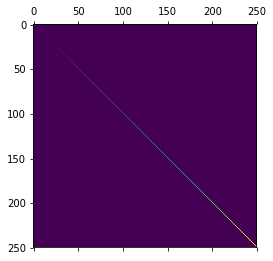

In [11]:
plt.matshow(covar_z)

<div class="alert alert-block alert-info">
<b>¿Por qué tiene esa forma?</b>
</div>

Tu respuesta:

...

## Sobre  p(x|z) y su cálculo

Como sabes

\begin{equation}
p(x|z) = \mathcal{N}(x|Wz,\sigma^2I)\
\end{equation}

Estamos usando los estimadores de máxima verosimilitud $W_{ml}$ y $\sigma^2_{ml}$ que ya hemos calculado. Así pues, esta distribución la podemos calcular muy fácilmente y solo hace falta que nos decidamos por el $z$ que vamos a usar. 

<div class="alert alert-block alert-info">
<b>Fijando z a las medias que hay en mean_Z calcula la media de cada una de las distribuciones p(x|z) y calcula también la matriz de covarianza de esta distribución. Las llamaremos mean_cond_X y covar_cond_x, respectivamente. Es importante que esté claro para ti cuales son sus dimensiones.</b>
</div>

Observa que no es eficiente almacenar, por ejemplo, la matriz de covarianza pero nos permite fijar conceptos. 

In [ ]:
mean_cond_X = 

covar_cond_x =

print('mean_cond_X',mean_cond_X.shape)
print('covar_cond_x',covar_cond_x.shape)

## Trabajando con p(x|z) y p(z|x) y comparando con PCA


Ya que tenemos todos los ingredientes podemos empezar a utilizar las distribuciones que hemos calculado. 

<div class="alert alert-block alert-info">
<b> A partir de X_norm hemos calculado mean_Z y cov_z, es decir, la media y la matriz de covarianza de $p(z|x)$. 
    
1. Usa mean_Z para calcular la media de $p(x|z)$ para todos los ejemplos del conjunto de entrenamiento, almacénalas en X_rec. 
2. Calcula también las reconstrucciones por PCA. Almacénalas en X_rec_pca 

Cuando lo tengas, observa que la figura muestra las 5 primeras caras ruidosas de la base de datos original (primera fila), sus reconstrucciones con PPCA (segunda fila), y sus reconstrucción con PCA, (tercera fila). La cuarta fila muestra las imágenes originales.</b>
</div>

Observa que estamos llevando las imagenes ruidosas observadas a un espacio latente y luego de nuevo al espacio original.

In [ ]:
# Para PPCA
X_rec=

# Para PCA
X_rec_pca =

n_caras=5
n_row=4
plt.figure(figsize=(15,10))
for i in range(n_caras):
    plt.subplot(n_row,n_caras,i+1)
    I = np.reshape(X_noisy[i,:],[32,32]).T
    plt.imshow(I,cmap='gray')
    plt.title('Ruidosa')
    plt.axis('off')
        
    plt.subplot(n_row,n_caras,i+1*n_caras+1)
    I = np.reshape(X_rec[i,:],[32,32]).T
    plt.imshow(I,cmap='gray')
    plt.title('PPCA')
    plt.axis('off')
    
    plt.subplot(n_row,n_caras,i+2*n_caras+1)
    I = np.reshape(X_rec_pca[i,:],[32,32]).T
    plt.imshow(I,cmap='gray')
    plt.title('PCA')
    plt.axis('off')
    
    plt.subplot(n_row,n_caras,i+3*n_caras+1)
    I = np.reshape(data[i,:],[32,32]).T
    plt.imshow(I,cmap='gray')
    plt.title('Original')
    plt.axis('off')


Podría pensarse que la reconstrucción de las caras original es mejor con PCA que con PPCA. Piensa sobre quien generalizará mejor a caras no vistas.

## Usando p(x|z) para obtener distintas muestras

Antes hemos mostrado la media de la distribución $p(x|z)$, pero ahora probaremos a muestrearla.

<div class="alert alert-block alert-info">
<b>Has calculado antes mean_cond_X y covar_cond_x. Utiliza la clase multivariate_normal de numpy.random para generar 5 muestras de la primera cara del dataset, debes almacenarlas en X_muestras_1, luego debes deshacer la transformación incial y almacenar las muestras en X_muestras_rec_1. Muestra las 5 imagenes que obtienes.</b>
</div>

Piensa qué harías si quisieras hacer lo mismo con PCAs.

In [ ]:
np.random.seed(42)

X_muestras_1=
X_muestras_rec_1 = 

plt.figure(figsize=(15,5))
for i in range(n_caras):
    plt.subplot(2,n_caras,i+1)
    I = np.reshape(X_muestras_rec_1[i,:],[32,32]).T
    plt.imshow(I,cmap='gray')
    plt.title('Muestra p(x|z)')
    plt.axis('off')

## Modelo generativo

Disponer de la distribución a priori $p(z)={\mathcal{N}}(0,I)$ nos permite generar caras.

<div class="alert alert-block alert-info">
<b>Utiliza la clase normal de numpy.random para generar 5 muestras de p(z), las llamamos Z_gen. Par cada una de estas zs muestra la media de p(x|z) y almacénalas todas en X_gen. Luego reconstruye (dehaz la transformación) y muéstralas.</b>
</div>


In [ ]:
np.random.seed(42)
Z_gen=np.random.normal(0,1,[n_componentes,5])
X_gen=
X_gen_rec= 

n_caras=5
plt.figure(figsize=(15,5))
for i in range(n_caras):
    plt.subplot(2,n_caras,i+1)
    I = np.reshape(X_gen_rec[i,:],[32,32]).T
    plt.imshow(I,cmap='gray')
    plt.title('Original')
    plt.axis('off')

# Distribución marginal p(x)

Integrando en z la distribución conjunta p(x,z) podemos obtener la distribución marginal p(x).

\begin{equation}
    p(x)=\int p(x|z)p(z)\mbox{d}z={\cal N}(x|0,C),
\end{equation}

donde 

\begin{equation}
C=WW^T+\sigma^2I.
\end{equation}

<div class="alert alert-block alert-info">
<b>Calcula la matriz C, su determinante y su inversa. Observa que podemos realizar estos cálculos porque el número de rasgos es pequeño. Si tuviésemos menos instancias que rasgos sería mejor usar la identidad de Woodbury y si ambos son muy grandes tendríamos un problema (que es posible solucionar).</b>
</div>

In [ ]:
C = 
det_C=
C_inv=

plt.matshow(C)

<div class="alert alert-block alert-info">
<b>Utiliza la clase multivariate_normal de numpy.random para generar 5 muestras de la distribución marginal p(x), almacénalas en X_muestras. No te confundas, no estás generando necesariamente caras similares a las que has aprendido. Observa que no estás observando una x para generar una z, y a partir de z recuperar x.
    
Muestra las 5 imagenes que obtienes. No olvides, como siempre, deshacer la normalización. Las caras sin la normalización debes almacenarlas en X_muestras_rec.</b>
</div>

In [ ]:
np.random.seed(42)

X_muestras=
X_muestras_rec=

n_caras=5
plt.figure(figsize=(15,15))
for i in range(n_caras):
    plt.subplot(2,n_caras,i+1)
    I = np.reshape(X_muestras_rec[i,:],[32,32]).T
    plt.imshow(I,cmap='gray')
    plt.title('Muestra de p(x)')
    plt.axis('off')

# Ln P(x)

Estimados $W_{ml}$  y $\sigma^2_{ml}$ podemos calcular el logaritmo de la probabilidad de una observación x:

\begin{equation}
\ln p(x|W_{\mbox{ML}},sigma_{\mbox{ML}}^2)=-\frac{M}{2}\ln(2\pi)-\frac{1}{2}\ln|C|-\frac{1}{2}\color{red}{x^TC^{-1}x} 
\end{equation} 

Puede usarse para identificar anomalías con respecto a las imágenes que hemos utilizado para aprender nuestro modelo. Como todos los términos de la derecha de la ecuación anterior son constantes salvo en que esta en rojo, vamos a calcularlo.

<div class="alert alert-block alert-info">
<b>Calcula $x^TC^{-1}x$ para cada muestra x en X_norm y almacenalo en X_error que obviamente será un vector con tantas componentes como datos en el conjunto de entrenamiento, es decir (4500,).</b>
</div>

In [ ]:
X_error=

Usando los errores que has calculado vamos a mostrar la cara que tiene mayor probabilidad.

In [ ]:
index_min_error=np.argmin(X_error)
print("Índice de la cara más probable: {}".format(1+index_min_error))
I = np.reshape(X_rec[index_min_error,:],[32,32]).T
plt.imshow(I,cmap='gray')
plt.title('Más probable')
plt.axis('off')

Usando los errores que has calculado vamos a mostrar la cara que tiene menor probabilidad.

In [ ]:
index_max_error=np.argmax(X_error)
print("Índice de la cara menos probable: {}".format(1+index_max_error))
I = np.reshape(X_rec[index_max_error,:],[32,32]).T
plt.imshow(I,cmap='gray')
plt.title('Menos probable')
plt.axis('off')

# Test

Para terminar este guión vamos a ver como de probables son nuestras datos de test.


<div class="alert alert-block alert-info">
<b>Encuentra y muestra la cara de test que es más probable y la menos probable, con el modelo que hemos construido.</b>
</div>

In [ ]:
# Tu código


# Para terminar

Nos hemos dejado muchas cosas interesantes por hacer. Te sugiero que pienses en las siguientes y escribas el código que te permita analizar lo que está pasando. Si quieres inclúyelo aquí [OPCIONAL]. Te dejo dos preguntas:

1. ¿Qué diferencias habrá entre el espacio latente de las PCAs y de las PPCAs. Sí, el de las PCAs es determinista. ¿Cuáles serán las implicaciones?

2. Piensa en la base de datos MNIST. ¿Qué te gustaría que pasase en el espacio latente de las PPCA?, ¿Sería bueno que cada dígito estuviera separado, en su representación latente, de los otros dígitos?

3. Sí, he dicho dos pero una más para terminar. ¿Se te ocurriría alguna forma de pasar de una cara a otra (o de un número a otro si usamos MNIST) en el espacio latente? Piensa en la segunda pregunta.